In [1]:
import datetime as dt
import numpy as np
import SEB_functions as SEBf
import matplotlib.pyplot as plt


In [2]:
SEBdata = SEBf.SEB_data(FileName="PKM-data/S10_SEB_2009_2019.txt")

The header has  88 entries.
AWS file 'S10_SEB_2009_2019.txt' has 91776 lines of data for 84 variables, start reading it.
Reading completed.
No data corrections needed for this station.


In [249]:
class CloseSEB():
    def __init__(self, SEBdata):
        self.T_air = SEBdata.Extract_Variable("Tair") + 273.15 # in degK
        self.T_surface = SEBdata.Extract_Variable("Tsurf_calc") + 273.15
        self.P = SEBdata.Extract_Variable("pres")
        self.U10 = SEBdata.Extract_Variable("FF_10m")
        self.RH = SEBdata.Extract_Variable("RH")/100 # in %
        self.SHF_initial = SEBdata.Extract_Variable("Hsen")
        self.G = SEBdata.Extract_Variable("Gs")
        self.SWdown = SEBdata.Extract_Variable("SWin_corr")
        self.SWup = SEBdata.Extract_Variable("SWout")
        self.SWnet = SEBdata.Extract_Variable("SWnet_corr")
        self.LWup = SEBdata.Extract_Variable("LWout_corr")
        self.LWdown = SEBdata.Extract_Variable("LWin")
        #Find the c_tbd array
        self.c_tbd = self.find_ctbd(SEBdata)

    def find_ctbd(self, SEBdata):
        '''Function to calculate infamous c_tbd'''
        SHF = self.SHF_initial
        T_air2m = SEBdata.Extract_Variable('Tair_2m') + 273.15 # in degK
        T_surf = self.T_surface
        c_tbd = np.array(SHF)/(self.U10* (np.array(T_air2m) - np.array(T_surf)))
        c_tbd = np.array(c_tbd)
        c_tbd[c_tbd < 0] = 0
        c_tbd[c_tbd > 5] = 5
        c_tbd[c_tbd == np.nan] = 0

        self.c_tbd = c_tbd
        return c_tbd
    
    def print_var(self, var):
        return getattr(self, var)


    def LWadjdown(self, Tatm, dT):
        '''Function to convert temperature anomaly to LW down in W/m2'''
        LW_adj_down = SEBf.convert_T_in_LWout(Tatm + dT, Celcius=False)*-1 
        return LW_adj_down
    
    def find_LHF(self,T, P, U10, RH):
        '''Function to calculate the latent heat flux from the 2m temperature, pressure, relative humidity and wind speed'''
        mv = 18.0153 #g/mol
        mair = 28.9644 #g/mol

        if T <= 273.15:
            c_1 = 22.587
            c_2 = 273.68 #in C
        elif T > 273.15:
            c_1 = 17.502
            c_2 = 240.97 #in C
        else:
            return np.nan
        
        cs = 1 #TODO check if cl is one <-- apparently proportional to cs?! --> set same as c_tbd
        Qsat = 6.1121*mv/(P*mair)*np.exp(c_1*(T - 273.15)/(c_2+(T - 273.15))) #TODO Check if RH is in % 
        LHF =  cs * U10 * ((RH-1)*Qsat) 
        return LHF
    
   
    
    def calc_Tsurf(self,T_surf_est,dT,LWadjdown,P,U10,RH,SWnet,c_tbd,SHF,G,get_Fluxes=False):
        '''Calculate the surface temperature from the bulk temperature and the wind speed'''
        sigma=5.67e-8
        LHF = self.find_LHF(T_surf_est,P, U10, RH)

        c_adj = 4*(T_surf_est**3)*sigma + c_tbd*U10
        c_fixed = SWnet + LWadjdown + 3*sigma*T_surf_est**4 + SHF + U10*c_tbd*(dT+T_surf_est) + LHF + G
        
        T_surf_adj =  c_fixed/c_adj
        
        if not get_Fluxes:
            return T_surf_adj
        
        if get_Fluxes:
            LW_adj_up = -sigma*(T_surf_est)**4 - 4*sigma*(T_surf_est**3)*(T_surf_adj-T_surf_est)
            LW_adj_down = sigma*(T_surf_adj)**4
            SHF_adj = SHF+U10*c_tbd*(dT+T_surf_est)
            shf_res = 0#U10*c_tbd*(dT+T_surf_est)

            LHF_adj = LHF
            return LW_adj_up, LW_adj_down,SHF_adj, LHF_adj, shf_res
        
    def calculate_melting(self,T_surf,dT,LWadjdown,P,U10,RH,SWnet,c_tbd,SHF,G,get_Fluxes=False):
        '''Function to calculate the melting energy from the surface temperature, pressure, relative humidity and wind speed''' 
        sigma= 5.67e-8
        LHF = self.find_LHF(T_surf,P, U10, RH)
        
        c_adj = 4*(T_surf**3)*sigma + c_tbd*U10
        c_fixed = SWnet + LWadjdown + 3*sigma*(T_surf**4) + SHF + U10*c_tbd*(dT+T_surf) + LHF + G

        M = (c_fixed-c_adj*T_surf) 

        return M
    
    def calculate_SEB(self,T_surface, dT,LWadjdown,P,U10,RH,SWnet,c_tbd,SHF,G,idx=0,idxmax=10,get_Fluxes=False):
        ''''Function to calculate the surface energy balance from the surface temperature, pressure, relative humidity and wind speed'''
        T_surf_updated = self.calc_Tsurf(T_surface,dT,LWadjdown,P=P,U10=U10,RH=RH,SWnet=SWnet,c_tbd=c_tbd,SHF=SHF,G=G,get_Fluxes=False) 
        # print(T_surface, dT,LWadjdown,P,U10,RH,SWnet,c_tbd,SHF,G,idx,idxmax,get_Fluxes)
        if not get_Fluxes:
            if T_surf_updated > 273.15:
                M = self.calculate_melting(T_surf=273.16,dT=1,LWadjdown=LWadjdown,P=P,U10=U10,RH=RH,SWnet=SWnet,c_tbd=c_tbd,SHF=SHF,G=G)
                res = 0
                T_surf = 273.16
                return M, res, T_surf 
            
            else: 
                if idx == idxmax:
                    res = self.calculate_melting(T_surf_updated,dT=1,LWadjdown=LWadjdown,P=P,U10=U10,RH=RH,SWnet=SWnet,c_tbd=c_tbd,SHF=SHF,G=G)
                    if res > 0:
                        M = res
                        res = 0
                        T_surf = 273.16
                    else:
                        M = 0
                        T_surf = T_surf_updated
                    return M, res, T_surf
                
                if T_surf_updated <= 273.15:
                    return self.calculate_SEB(T_surface=T_surf_updated,dT=1,LWadjdown=LWadjdown,P=P,U10=U10,RH=RH,SWnet=SWnet,c_tbd=c_tbd,SHF=SHF,G=G,idx=idx+1)
                
                else: # T_comp is a nan or something
                    return np.nan, np.nan, np.nan
                
        if get_Fluxes:
            LW_adj_up, LW_adj_down, SHF_adj, LHF_adj,shf_res_adj = self.calc_Tsurf(T_surf_est=T_surf_updated,dT=1,LWadjdown=LWadjdown,P=P,U10=U10,RH=RH,SWnet=SWnet,c_tbd=c_tbd,SHF=SHF,G=G,get_Fluxes=True) 
            return LW_adj_up, LW_adj_down,SHF_adj, LHF_adj,shf_res_adj
    
    def fetch_SEB(self, LWadjdown, dT,get_Fluxes=False):
        '''Function to fetch the SEB'''
        SEB_dict = {}
        M_ar = []
        res_ar = [] 
        T_surf_ar = [] 

        LW_adj_up_arr = []
        LW_adj_down_arr = []
        SHF_adj_arr = []
        LHF_adj_arr = []
        shf_adj_arr = []

        
        for idx, (T_s, P, RH, c_tbd,U10, SWnet, LWad, SHF, G) in enumerate(zip(self.T_surface, self.P, self.RH, self.c_tbd,self.U10,self.SWnet,LWadjdown,self.SHF_initial,self.G)):
            # print(T_s, P, RH, c_tbd,U10, SWnet, LWad, SHF, G)
            M, res, T_surf = self.calculate_SEB(T_surface=T_s,dT=dT,LWadjdown=LWad,P=P,U10=U10,RH=RH,SWnet=SWnet,c_tbd=c_tbd,SHF=SHF,G=G,idxmax=10,get_Fluxes=False)
            M_ar.append(M)
            res_ar.append(res)
            T_surf_ar.append(T_surf)
            
            if get_Fluxes:
                LW_adj_up, LW_adj_down, SHF_adj, LHF_adj,shf_res_adj = self.calculate_SEB(T_s, dT,LWad,P,U10,RH,SWnet,c_tbd,SHF,G,idxmax=10,get_Fluxes=True)
                LW_adj_up_arr.append(LW_adj_up)
                LW_adj_down_arr.append(LW_adj_down)
                SHF_adj_arr.append(SHF_adj)
                LHF_adj_arr.append(LHF_adj)
                shf_adj_arr.append(shf_res_adj)

        SEB_dict = {'Melt': M_ar, 'Res': res_ar, 'T_surf': T_surf_ar}
        if get_Fluxes:
            SEB_dict.update({'LW_adj_up': LW_adj_up_arr, 'LW_adj_down': LW_adj_down_arr, 'SHF_adj': SHF_adj_arr, 'LHF_adj': LHF_adj_arr, 'shf_res_adj': shf_adj_arr})
        return SEB_dict
        


    

In [250]:
CloseSEB = CloseSEB(SEBdata)

C:\Users\lasse\AppData\Local\Temp\ipykernel_884\3023794546.py:23: RuntimeWarning: divide by zero encountered in divide
  c_tbd = np.array(SHF)/(self.U10* (np.array(T_air2m) - np.array(T_surf)))


In [251]:
SHF_initial = CloseSEB.print_var("SHF_initial")
U10 = CloseSEB.print_var("U10")


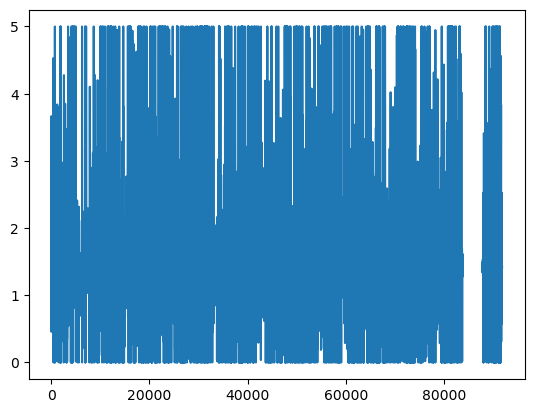

In [252]:
plt.plot(CloseSEB.print_var('c_tbd'))
# print(c_tbd.max())

In [253]:
LWadjdown = CloseSEB.LWadjdown(CloseSEB.T_air, 1)

In [254]:
melt_dict_fluxes = CloseSEB.fetch_SEB(LWadjdown=LWadjdown, dT=1,get_Fluxes=True)

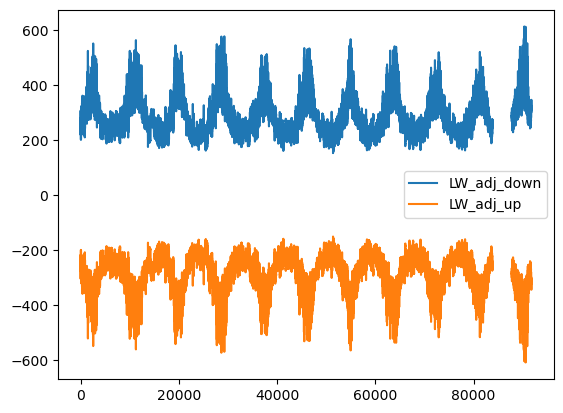

In [255]:
plt.plot(melt_dict_fluxes['LW_adj_down'], label='LW_adj_down')
plt.plot(melt_dict_fluxes['LW_adj_up'], label='LW_adj_up')
plt.legend()

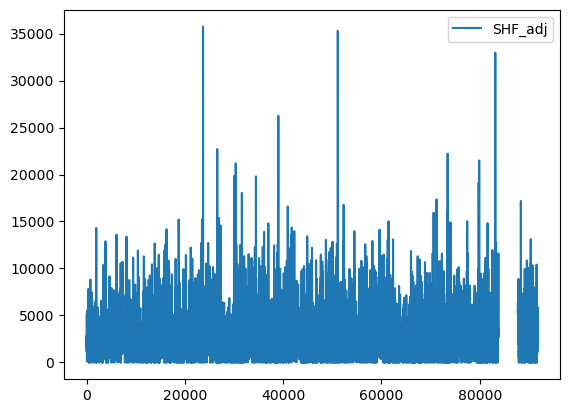

In [256]:
plt.plot(melt_dict_fluxes['SHF_adj'], label='SHF_adj')
# plt.plot(melt_dict_fluxes['LHF_adj'], label='LHF_adj')
plt.legend()

In [159]:
class CloseSEB_FUCKTHESHF():
    def __init__(self, SEBdata):
        self.T_air = SEBdata.Extract_Variable("Tair") + 273.15 # in degK
        self.T_surface = SEBdata.Extract_Variable("Tsurf_calc") + 273.15
        self.P = SEBdata.Extract_Variable("pres")
        self.U10 = SEBdata.Extract_Variable("FF_10m")
        self.RH = SEBdata.Extract_Variable("RH")/100 # in %
        self.SHF_initial = SEBdata.Extract_Variable("Hsen")
        self.G = SEBdata.Extract_Variable("Gs")
        self.SWdown = SEBdata.Extract_Variable("SWin_corr")
        self.SWup = SEBdata.Extract_Variable("SWout")
        self.SWnet = SEBdata.Extract_Variable("SWnet_corr")
        self.LWup = SEBdata.Extract_Variable("LWout_corr")
        self.LWdown = SEBdata.Extract_Variable("LWin")
        self.T2m = SEBdata.Extract_Variable('Tair_2m')
        #Find the c_tbd array
        self.c_tbd = self.find_ctbd(SEBdata)

    def find_ctbd(self, SEBdata):
        '''Function to calculate infamous c_tbd'''
        SHF = self.SHF_initial
        T_air2m = SEBdata.Extract_Variable('Tair_2m') + 273.15 # in degK
        T_surf = self.T_surface
        c_tbd = np.array(SHF)/(np.array(T_air2m) - np.array(T_surf))
        c_tbd = np.array(c_tbd)
        c_tbd[c_tbd < 0] = 0
        c_tbd[c_tbd > 50] = 50

        self.c_tbd = c_tbd
        return c_tbd
    


    def LWadjdown(self, Tatm, dT):
        '''Function to convert temperature anomaly to LW down in W/m2'''
        LW_adj_down = SEBf.convert_T_in_LWout(Tatm + dT, Celcius=False)*-1 
        return LW_adj_down
    
    def find_LHF(self, T, P, U10, RH):
        '''Function to calculate the latent heat flux from the 2m temperature, pressure, relative humidity and wind speed'''
        mv = 18.0153 #g/mol
        mair = 28.9644 #g/mol

        if T <= 273.15:
            c_1 = 22.587
            c_2 = 273.68 #in C
        elif T > 273.15:
            c_1 = 17.502
            c_2 = 240.97 #in C
        else:
            return np.nan
        
        cs = 1 #TODO check if cl is one <-- apparently proportional to cs?! --> set same as c_tbd
        Qsat = 6.1121*mv/(P*mair)*np.exp(c_1*(T - 273.15)/(c_2+(T - 273.15))) #TODO Check if RH is in % 
        LHF =  cs * U10 * ((RH-1)*Qsat) 
        return LHF
    
   
    
    def calc_Tsurf(self,T_surf_est,dT,LWadjdown,P,U10,RH,SWnet,c_tbd,SHF,G,T2m,get_Fluxes=False):
        '''Calculate the surface temperature from the bulk temperature and the wind speed'''
        sigma=5.67e-8
        LHF = self.find_LHF(T_surf_est,P, U10, RH)

        c_adj = 4*(T_surf_est**3)*sigma 
        c_fixed = SWnet + LWadjdown + 3*sigma*T_surf_est**4 + U10*c_tbd*(T2m-T_surf_est) + LHF + G
        
        T_surf_adj =  c_fixed/c_adj
        
        if not get_Fluxes:
            return T_surf_adj
        
        if get_Fluxes:
            LW_adj_up = -sigma*(T_surf_est)**4 - 4*sigma*(T_surf_est**3)*(T_surf_adj-T_surf_est)
            LW_adj_down = sigma*(T_surf_adj)**4
            SHF_adj = U10*c_tbd*(T2m-T_surf_est)
            LHF_adj = LHF
            return LW_adj_up, LW_adj_down,SHF_adj, LHF_adj
        
    def calculate_melting(self,T_surf,dT,LWadjdown,P,U10,RH,SWnet,c_tbd,SHF,G,T2m,get_Fluxes=False):
        '''Function to calculate the melting energy from the surface temperature, pressure, relative humidity and wind speed''' 
        sigma= 5.67e-8
        LHF = self.find_LHF(T_surf,P, U10, RH)
        
        c_adj = 4*(T_surf**3)*sigma 
        c_fixed = SWnet + LWadjdown + 3*sigma*(T_surf**4) + U10*c_tbd*(T2m-T_surf) + LHF + G

        M = (c_fixed-c_adj*T_surf) 

        return M
    
    def calculate_SEB(self,T_surface, dT,LWadjdown,P,U10,RH,SWnet,c_tbd,SHF,G,T2m,idx=0,idxmax=10,get_Fluxes=False):
        ''''Function to calculate the surface energy balance from the surface temperature, pressure, relative humidity and wind speed'''
        T_surf_updated = self.calc_Tsurf(T_surface,dT,LWadjdown,P=P,U10=U10,RH=RH,SWnet=SWnet,c_tbd=c_tbd,SHF=SHF,G=G,T2m=T2m,get_Fluxes=False) 
        # print(T_surface, dT,LWadjdown,P,U10,RH,SWnet,c_tbd,SHF,G,idx,idxmax,get_Fluxes)
        if not get_Fluxes:
            if T_surf_updated > 273.15:
                M = self.calculate_melting(T_surf=273.16,dT=1,LWadjdown=LWadjdown,P=P,U10=U10,RH=RH,SWnet=SWnet,c_tbd=c_tbd,SHF=SHF,G=G,T2m=T2m)
                res = 0
                T_surf = 273.16
                return M, res, T_surf 
            
            else: 
                if idx == idxmax:
                    res = self.calculate_melting(T_surf_updated,dT=1,LWadjdown=LWadjdown,P=P,U10=U10,RH=RH,SWnet=SWnet,c_tbd=c_tbd,SHF=SHF,G=G,T2m=T2m)
                    if res > 0:
                        M = res
                        res = 0
                        T_surf = 273.16
                    else:
                        M = 0
                        T_surf = T_surf_updated
                    return M, res, T_surf
                
                if T_surf_updated <= 273.15:
                    return self.calculate_SEB(T_surface=T_surf_updated,dT=1,LWadjdown=LWadjdown,P=P,U10=U10,RH=RH,SWnet=SWnet,c_tbd=c_tbd,SHF=SHF,G=G,T2m=T2m,idx=idx+1)
                
                else: # T_comp is a nan or something
                    return np.nan, np.nan, np.nan
                
        if get_Fluxes:
            LW_adj_up, LW_adj_down, SHF_adj, LHF_adj = self.calc_Tsurf(T_surf_est=T_surf_updated,dT=1,LWadjdown=LWadjdown,P=P,U10=U10,RH=RH,SWnet=SWnet,c_tbd=c_tbd,SHF=SHF,G=G,T2m=T2m,get_Fluxes=True) 
            return LW_adj_up, LW_adj_down,SHF_adj, LHF_adj
    
    def fetch_SEB(self, LWadjdown, dT,get_Fluxes=False):
        '''Function to fetch the SEB'''
        SEB_dict = {}
        M_ar = []
        res_ar = [] 
        T_surf_ar = [] 

        LW_adj_up_arr = []
        LW_adj_down_arr = []
        SHF_adj_arr = []
        LHF_adj_arr = []

        
        for idx, (T_s, P, RH, c_tbd,U10, SWnet, LWad, SHF, G,T2m) in enumerate(zip(self.T_surface, self.P, self.RH, self.c_tbd,self.U10,self.SWnet,LWadjdown,self.SHF_initial,self.G,self.T2m)):
            # print(T_s, P, RH, c_tbd,U10, SWnet, LWad, SHF, G)
            M, res, T_surf = self.calculate_SEB(T_surface=T_s,dT=dT,LWadjdown=LWad,P=P,U10=U10,RH=RH,SWnet=SWnet,c_tbd=c_tbd,SHF=SHF,G=G,T2m=T2m,idxmax=10,get_Fluxes=False)
            M_ar.append(M)
            res_ar.append(res)
            T_surf_ar.append(T_surf)
            
            if get_Fluxes:
                LW_adj_up, LW_adj_down, SHF_adj, LHF_adj = self.calculate_SEB(T_s, dT,LWad,P,U10,RH,SWnet,c_tbd,SHF,G,T2m,idxmax=10,get_Fluxes=True)
                LW_adj_up_arr.append(LW_adj_up)
                LW_adj_down_arr.append(LW_adj_down)
                SHF_adj_arr.append(SHF_adj)
                LHF_adj_arr.append(LHF_adj)

        SEB_dict = {'Melt': M_ar, 'Res': res_ar, 'T_surf': T_surf_ar}
        if get_Fluxes:
            SEB_dict.update({'LW_adj_up': LW_adj_up_arr, 'LW_adj_down': LW_adj_down_arr, 'SHF_adj': SHF_adj_arr, 'LHF_adj': LHF_adj_arr})
        return SEB_dict
        


    

In [161]:
sebc = CloseSEB_FUCKTHESHF(SEBdata)

C:\Users\lasse\AppData\Local\Temp\ipykernel_884\3424737812.py:24: RuntimeWarning: divide by zero encountered in divide
  c_tbd = np.array(SHF)/(np.array(T_air2m) - np.array(T_surf))


In [163]:
arr = sebc.fetch_SEB(LWadjdown=LWadjdown, dT=1,get_Fluxes=True)

C:\Users\lasse\AppData\Local\Temp\ipykernel_884\3424737812.py:75: RuntimeWarning: overflow encountered in scalar power
  LW_adj_down = sigma*(T_surf_adj)**4
C:\Users\lasse\AppData\Local\Temp\ipykernel_884\3424737812.py:54: RuntimeWarning: overflow encountered in exp
  Qsat = 6.1121*mv/(P*mair)*np.exp(c_1*(T - 273.15)/(c_2+(T - 273.15))) #TODO Check if RH is in %
C:\Users\lasse\AppData\Local\Temp\ipykernel_884\3424737812.py:55: RuntimeWarning: invalid value encountered in scalar multiply
  LHF =  cs * U10 * ((RH-1)*Qsat)
C:\Users\lasse\AppData\Local\Temp\ipykernel_884\3424737812.py:68: RuntimeWarning: overflow encountered in scalar divide
  T_surf_adj =  c_fixed/c_adj


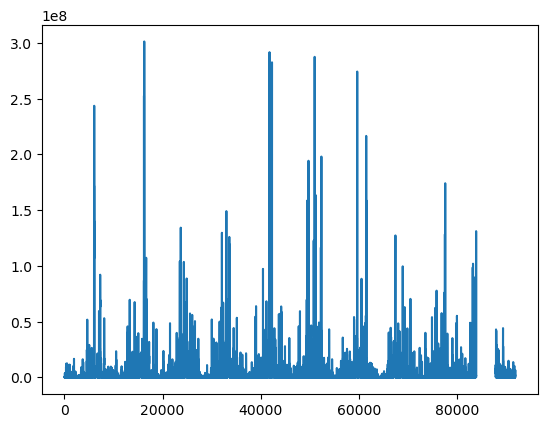

In [169]:
# plt.plot(arr['Melt'])
# plt.plot(arr['Res'])
plt.plot(arr['SHF_adj'])